In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Change to the content directory to ensure consistent path
%cd /content/

# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git

# Change directory to yolov5 for installation and execution
%cd yolov5

# Install dependencies (this might take a few minutes)
!pip install -r requirements.txt

# Install opencv-python for video/webcam processing
!pip install opencv-python

# Install firebase-admin for Firestore
!pip install firebase-admin

# Verify PyTorch and GPU setup
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: CUDA (GPU) is not available. Inference will run on CPU, which is much slower.")

# Check if YOLOv5 setup is complete
import os
assert os.path.exists('models/yolo.py'), "YOLOv5 repository not cloned correctly!"
print("\nYOLOv5 and dependencies installed successfully!")


/content
Cloning into 'yolov5'...
remote: Enumerating objects: 17511, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17511 (delta 5), reused 0 (delta 0), pack-reused 17491 (from 3)
Receiving objects: 100% (17511/17511), 16.60 MiB | 24.36 MiB/s, done.
Resolving deltas: 100% (11993/11993), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 

In [15]:
import shutil
import firebase_admin
from firebase_admin import credentials, firestore
from datetime import datetime
import os

# --- IMPORTANT: Adjust this path to where you uploaded your serviceAccountKey.json in Google Drive ---
SERVICE_ACCOUNT_KEY_PATH_IN_DRIVE = '/content/drive/MyDrive/firebase_keys/serviceAccountKey.json'
# Local path within the Colab session
SERVICE_ACCOUNT_KEY_PATH_LOCAL = '/content/serviceAccountKey.json'

# Copy the service account key from Drive to the current Colab session
try:
    if not os.path.exists(SERVICE_ACCOUNT_KEY_PATH_LOCAL):
        shutil.copy(SERVICE_ACCOUNT_KEY_PATH_IN_DRIVE, SERVICE_ACCOUNT_KEY_PATH_LOCAL)
        print(f"Service account key copied to {SERVICE_ACCOUNT_KEY_PATH_LOCAL}")
    else:
        print("Service account key already exists locally. Skipping copy.")
except FileNotFoundError:
    print(f"ERROR: serviceAccountKey.json not found at {SERVICE_ACCOUNT_KEY_PATH_IN_DRIVE}")
    print("Please ensure you've uploaded your serviceAccountKey.json to Google Drive and set the correct path above.")
except Exception as e:
    print(f"An error occurred while copying the key: {e}")

# Initialize Firebase Admin SDK
db = None
if not firebase_admin._apps:
    try:
        if os.path.exists(SERVICE_ACCOUNT_KEY_PATH_LOCAL):
            cred = credentials.Certificate(SERVICE_ACCOUNT_KEY_PATH_LOCAL)
            firebase_admin.initialize_app(cred)
            print("Firebase Admin SDK initialized successfully!")
            db = firestore.client()
        else:
            print("Cannot initialize Firebase: serviceAccountKey.json not found locally.")
    except Exception as e:
        print(f"Failed to initialize Firebase Admin SDK: {e}")
        print("Please ensure your serviceAccountKey.json is valid and accessible.")
else:
    print("Firebase Admin SDK already initialized.")
    db = firestore.client() # Get the client if already initialized

# Define the logging function
def log_detection_to_firestore(label, xmin, ymin, xmax, ymax, confidence, timestamp, source_type="image", image_b64=None):
    """Logs detection data to Firestore."""
    if db is None:
        print("Firestore DB client not initialized. Skipping logging.")
        return

    try:
        doc_ref = db.collection('detections').document()
        data = {
            'label': label,
            'bbox': {'xmin': float(xmin), 'ymin': float(ymin), 'xmax': float(xmax), 'ymax': float(ymax)},
            'confidence': float(confidence),
            'timestamp': timestamp,
            'source_type': source_type,
        }
        if image_b64:
            data['image_b64'] = image_b64 # Store base64 encoded image (be mindful of Firestore limits)

        doc_ref.set(data)
        # print(f"Logged detection: {label} at {timestamp}")
    except Exception as e:
        print(f"Error logging to Firestore: {e}")

print("\nFirestore logging function defined.")

Service account key copied to /content/serviceAccountKey.json
Firebase Admin SDK initialized successfully!

Firestore logging function defined.


In [29]:
%%writefile run_detector.py

import torch
import cv2
import numpy as np
from datetime import datetime
from PIL import Image as PILImage
import io
import base64
import os
import time
import sys

# Firebase imports (assumed to be installed and initialized in the Colab notebook)
try:
    import firebase_admin
    from firebase_admin import credentials, firestore
    db = None
    if firebase_admin._apps:
        db = firestore.client()
        print("Firebase DB client successfully accessed in run_detector.py.")
    else:
        print("Firebase Admin SDK not initialized outside run_detector.py. Firestore logging will be skipped.")
except ImportError:
    db = None
    print("Firebase Admin SDK not installed or configured. Skipping Firestore logging in run_detector.py.")


def log_detection_to_firestore(label, xmin, ymin, xmax, ymax, confidence, timestamp, source_type="image", image_b64=None):
    """Logs detection data to Firestore."""
    global db

    if db is None:
        print("Firestore DB client not initialized. Skipping logging.") # This print can stay for initial verification
        return

    try:
        doc_ref = db.collection('detections').document()
        data = {
            'label': label,
            'bbox': {'xmin': float(xmin), 'ymin': float(ymin), 'xmax': float(xmax), 'ymax': float(ymax)},
            'confidence': float(confidence),
            'timestamp': timestamp,
            'source_type': source_type,
        }
        if image_b64:
            data['image_b64'] = image_b64

        doc_ref.set(data)
        # print(f"Logged detection: {label} at {timestamp}") # Uncomment this if you want verbose console logging
    except Exception as e:
        print(f"Error logging to Firestore: {e}")

def load_yolov5_model(weights_path='yolov5s.pt'):
    """Loads a YOLOv5 model."""
    try:
        model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path, force_reload=False)
        model.conf = 0.25
        model.iou = 0.45
        return model
    except Exception as e:
        print(f"Error loading YOLOv5 model: {e}")
        return None

def detect_and_log_image(model, image_path, confidence_threshold=0.25):
    """Performs detection on a static image, draws boxes, and logs to Firestore."""
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not load image from {image_path}")
            return None

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = model(img_rgb)

        detections = results.pandas().xyxy[0]
        timestamp = datetime.now().isoformat()

        img_with_boxes = img.copy()

        buffered = io.BytesIO()
        PILImage.fromarray(img_rgb).save(buffered, format="JPEG")
        img_b64 = base64.b64encode(buffered.getvalue()).decode('utf-8')

        print(f"\n--- Detections for {image_path} (Confidence Threshold: {confidence_threshold}) ---")
        if detections.empty:
            print("No objects detected above the confidence threshold.")
        else:
            print(detections[['name', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']])

        for *xyxy, conf, cls, name in detections.values:
            if conf >= confidence_threshold:
                xmin, ymin, xmax, ymax = map(int, xyxy)
                label = name
                confidence = float(conf)

                # RE-ENABLED FIRESTORE LOGGING
                log_detection_to_firestore(label, xmin, ymin, xmax, ymax, confidence, timestamp, "static_image", img_b64)

                color = (0, 255, 0)
                cv2.rectangle(img_with_boxes, (xmin, ymin), (xmax, ymax), color, 2)
                cv2.putText(img_with_boxes, f'{label} {confidence:.2f}', (xmin, ymin - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        print("--- End Detections ---")
        return img_with_boxes

    except Exception as e:
        print(f"Error during static image detection: {e}")
        return None

def run_webcam_detection(model, confidence_threshold=0.25):
    print("Starting webcam detection. Please grant camera access when prompted.")

    from IPython.display import display, Javascript, Image as IPDisplayImage
    from google.colab.output import eval_js
    from base64 import b64decode, b64encode

    def get_js_code():
        js = Javascript('''
            async function getPhoto(quality = 0.8) {
              const video = document.createElement('video');
              const stream = await navigator.mediaDevices.getUserMedia({video: true});
              document.body.appendChild(video);
              video.srcObject = stream;
              await video.play();
              google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
              return new Promise((resolve) => {
                const once = () => {
                  const canvas = document.createElement('canvas');
                  canvas.width = video.videoWidth;
                  canvas.height = video.videoHeight;
                  canvas.getContext('2d').drawImage(video, 0, 0);
                  const dataUrl = canvas.toDataURL('image/jpeg', quality);
                  stream.getVideoTracks()[0].stop();
                  document.body.removeChild(video);
                  resolve(dataUrl);
                };
                video.addEventListener('ended', once);
                video.addEventListener('pause', once);
              });
            }
            async function takePhoto(quality = 0.8) {
              const video = document.createElement('video');
              const stream = await navigator.mediaDevices.getUserMedia({video: true});
              document.body.appendChild(video);
              video.srcObject = stream;
              await video.play();
              google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
              let photo = '';
              try {
                await new Promise((resolve) => video.onplaying = resolve);
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                photo = canvas.toDataURL('image/jpeg', quality);
              } finally {
                stream.getVideoTracks()[0].stop();
                video.remove();
              }
              return photo;
            }
            ''')
        display(js)

    get_js_code()

    def js_to_image(js_reply):
        jpeg_bytes = b64decode(js_reply.split(',')[1])
        img_np = np.frombuffer(jpeg_bytes, dtype=np.uint8)
        img = cv2.imdecode(img_np, flags=1)
        return img

    while True:
        try:
            js_reply = eval_js('takePhoto()')
            img = js_to_image(js_reply)

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = model(img_rgb)

            detections = results.pandas().xyxy[0]
            timestamp = datetime.now().isoformat()

            img_display = img.copy()

            buffered = io.BytesIO()
            PILImage.fromarray(img_rgb).save(buffered, format="JPEG")
            img_b64 = base64.b64encode(buffered.getvalue()).decode('utf-8')

            for *xyxy, conf, cls, name in detections.values:
                if conf >= confidence_threshold:
                    xmin, ymin, xmax, ymax = map(int, xyxy)
                    label = name
                    confidence = float(conf)

                    # RE-ENABLED FIRESTORE LOGGING
                    log_detection_to_firestore(label, xmin, ymin, xmax, ymax, confidence, timestamp, "webcam_live", img_b64)

                    color = (0, 255, 0)
                    cv2.rectangle(img_display, (xmin, ymin), (xmax, ymax), color, 2)
                    cv2.putText(img_display, f'{label} {confidence:.2f}', (xmin, ymin - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            _, ret_arr = cv2.imencode('.jpg', img_display)
            jpg_as_text = base64.b64encode(ret_arr).decode()
            display(IPDisplayImage(data=b64decode(jpg_as_text)), display_id='live_feed')

            eval_js('document.getElementById("live_feed").src = "data:image/jpeg;base64," + "' + jpg_as_text + '";')

        except Exception as e:
            print(f"Error in webcam loop: {e}")
            break


def run_video_file_detection(model, confidence_threshold=0.25, video_path=None):
    """Runs object detection on a video file, draws boxes, and logs to Firestore."""
    print("DEBUG: Inside run_video_file_detection function with the latest code.") # Keep this for now

    if video_path is None:
        print("Error: No video path provided for run_video_file_detection.")
        return

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file {video_path}")
            return

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        print(f"Processing video: {video_path} (FPS: {fps}, Resolution: {frame_width}x{frame_height})")

        from IPython.display import HTML
        from base64 import b64encode
        from google.colab.patches import cv2_imshow

        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_count += 1

            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = model(img_rgb)

            detections = results.pandas().xyxy[0]
            timestamp = datetime.now().isoformat()

            buffered = io.BytesIO()
            PILImage.fromarray(img_rgb).save(buffered, format="JPEG")
            img_b64 = base64.b64encode(buffered.getvalue()).decode('utf-8')

            print(f"\n--- Detections for frame {frame_count} (Confidence Threshold: {confidence_threshold}) ---")
            if detections.empty:
                print("No objects detected in this frame.")
            else:
                print(detections[['name', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']])

            for *xyxy, conf, cls, name in detections.values:
                if conf >= confidence_threshold:
                    xmin, ymin, xmax, ymax = map(int, xyxy)
                    label = name
                    confidence = float(conf)

                    # RE-ENABLED FIRESTORE LOGGING
                    log_detection_to_firestore(label, xmin, ymin, xmax, ymax, confidence, timestamp, "video_file", img_b64)

                    color = (0, 255, 0)
                    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 2)
                    cv2.putText(frame, f'{label} {confidence:.2f}', (xmin, ymin - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            cv2_imshow(frame)

            delay = int(1000 / fps)
            time.sleep(delay / 1000.0)

        cap.release()
        print("Video processing finished.")

    except Exception as e:
        print(f"Error during video file detection: {e}")

if __name__ == '__main__':
    print("This script is designed to be imported and run in Google Colab cells.")
    print("Please execute the Colab cells in sequence.")

Overwriting run_detector.py


/content/yolov5
Firebase DB client successfully accessed in run_detector.py.


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-7-4 Python-3.11.13 torch-2.6.0+cu124 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 107MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Running detection on static image: data/images/zidane.jpg

--- Detections for data/images/zidane.jpg (Confidence Threshold: 0.4) ---
     name  confidence        xmin        ymin         xmax        ymax
0  person    0.879861  743.290527   48.343567  1141.756470  720.000000
1     tie    0.675118  441.989624  437.336731   496.585083  710.036194
2  person    0.666693  123.051178  193.238068   714.690796  719.771240
3     tie    0.261518  978.989807  313.579529  1025.302856  415.526184
--- End Detections ---
Detection results saved to detected_zidane.jpg


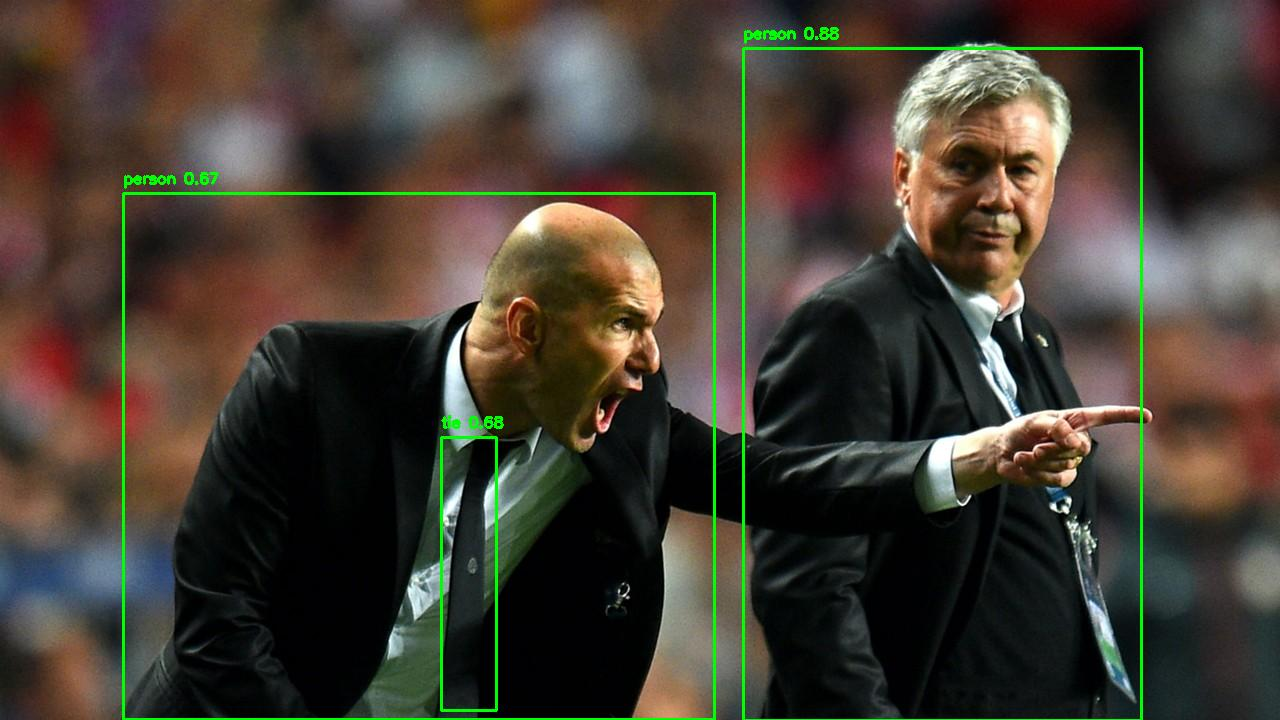

In [17]:
# Ensure we are in the yolov5 directory
%cd /content/yolov5

import sys
sys.path.append('/content/yolov5') # Add yolov5 to path if not already there

import cv2 # Import OpenCV
from PIL import Image as PILImage # Alias PIL.Image to avoid conflict
from IPython.display import Image as DisplayImage, display # Alias IPython.display.Image

from run_detector import load_yolov5_model, detect_and_log_image

# Load the YOLOv5 model (yolov5s.pt will be downloaded if not present)
model = load_yolov5_model('yolov5s.pt')

if model:
    # Path to an example image from the YOLOv5 repository
    image_path = 'data/images/zidane.jpg'
    # To use your own image:
    # 1. Upload it to Colab (e.g., drag and drop into files pane, or using google.colab.files.upload())
    # 2. Update image_path = '/content/your_uploaded_image.jpg'

    print(f"\nRunning detection on static image: {image_path}")
    output_image_np = detect_and_log_image(model, image_path, confidence_threshold=0.4)

    if output_image_np is not None:
        # Convert OpenCV BGR image to PIL Image for display in Colab
        output_image_rgb = cv2.cvtColor(output_image_np, cv2.COLOR_BGR2RGB)
        pil_img = PILImage.fromarray(output_image_rgb)

        # Save and display the image (optional, for verification)
        output_filename = 'detected_zidane.jpg'
        pil_img.save(output_filename)
        print(f"Detection results saved to {output_filename}")
        display(DisplayImage(filename=output_filename))
    else:
        print("Static image detection failed or no objects detected.")
else:
    print("Model not loaded, cannot run static image inference.")

video detection

In [6]:
!pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.6 MB/s eta 0:00:00


In [19]:
import os
import yt_dlp

youtube_url = "https://www.youtube.com/watch?v=kS-6ZCyDzKs" # Example: Traffic video

# Options for yt-dlp to download the video
ydl_opts = {
    'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
    'outtmpl': 'test_video.mp4', # Output filename
    'noplaylist': True,
    'quiet': True, # Suppress most output
}

print(f"Downloading video from: {youtube_url}")
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    info_dict = ydl.extract_info(youtube_url, download=True)
    video_filename = ydl.prepare_filename(info_dict)
print(f"Downloaded video to: {video_filename}")

# Now, use this video_filename in your run_video_file_detection call
# video_filename = '/content/yolov5/test_video.mp4' # It will be downloaded to current working directory, which is /content/yolov5

Downloaded video to: test_video.mp4


debbug now

In [18]:
# Ensure we are in the yolov5 directory
%cd /content/yolov5

import sys
sys.path.append('/content/yolov5')

# --- IMPORTLIB.RELOAD() IS THE KEY HERE ---
import importlib
import run_detector # Initial import or re-import
importlib.reload(run_detector) # Force reload the module after %%writefile
# Now, import the functions from the reloaded module
from run_detector import load_yolov5_model, run_video_file_detection
# --- END IMPORTLIB.RELOAD() ---

import os
from google.colab import files

# --- IMPORTANT: Ensure your video_filename is correct ---
# Using the path you previously provided for the downloaded video
video_filename = '/content/broadcast.mp4'

# Check if the video file exists before proceeding
if video_filename and not os.path.exists(video_filename):
    print(f"Error: Video file not found at {video_filename}.")
    print("Please ensure your video is at the specified path.")
    video_filename = None

if video_filename:
    # Load the YOLOv5 model
    model = load_yolov5_model('yolov5s.pt')

    if model:
        print(f"\nStarting video file detection for: {video_filename}")
        print("A video player will appear below the cell. It might take a moment to process.")
        print("To stop, you will need to interrupt the Colab cell execution (Runtime -> Interrupt execution).")
        # Pass the video_filename explicitly to the function
        run_video_file_detection(model, video_path=video_filename, confidence_threshold=0.4)
        print("Video detection complete or stopped.")
    else:
        print("Model not loaded, cannot run video file inference.")
else:
    print("Cannot proceed: Video file not found or not specified.")

/content/yolov5
Firebase DB client successfully accessed in run_detector.py.
Error: Video file not found at /content/broadcast.mp4.
Please ensure your video is at the specified path.
Cannot proceed: Video file not found or not specified.


In [1]:
%cd /content/

/content


In [2]:
!git clone https://github.com/ELITE-DEV-22/YOLOv5-Firebase-Detection.git

Cloning into 'YOLOv5-Firebase-Detection'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [3]:
# Move your Colab notebook into the root of your repo
!mv /content/YOLOv5_Firebase_Detection.ipynb /content/YOLOv5-Firebase-Detection/

# Create the yolov5 subfolder inside your repo if it doesn't exist
!mkdir -p /content/YOLOv5-Firebase-Detection/yolov5/

# Move run_detector.py into that subfolder
!mv /content/yolov5/run_detector.py /content/YOLOv5-Firebase-Detection/yolov5/

mv: cannot stat '/content/YOLOv5_Firebase_Detection.ipynb': No such file or directory
mv: cannot stat '/content/yolov5/run_detector.py': No such file or directory


In [7]:
!ls /content/
!ls /content/drive/MyDrive/
# If you save your notebooks in a specific folder in Drive, you might need to adjust this:
# !ls /content/drive/MyDrive/MyNotebooksFolder/

drive  sample_data  yolov5  YOLOv5-Firebase-Detection
 1.pdf.docx
 8051.gdoc
 9818_EXP1_EC.pdf
 9830_CE_EXP3.gdoc
 9830_DE_Exp1.gdoc
 9830_DE_EXP1.gdoc
 9830_DE_EXP2.gdoc
 9830_DE_EXP6.gdoc
 9830_Elita_Gonsalves.png
 9830_EXP10_ASIC.gdoc
 9830exp10.gdoc
 9830_EXP10_PYT.gdoc
 9830_EXP1_ASIC.gdoc
 9830_EXP1b_AI.gdoc
'9830_exp 1.docx'
'9830_EXP1_ESRTOS (1).gdoc'
 9830_EXP1_ESRTOS.gdoc
 9830_exp1.gdoc
'9830 EXP1.gdoc'
 9830_EXP1_LINUX.gdoc
'9830_exp2 (1).gdoc'
'9830_exp2 (2).gdoc'
 9830_EXP2_ASIC.gdoc
 9830_EXP2_DWM.gdoc
 9830_exp2.gdoc
 9830_exp2.pdf
 9830_EXP3_ASIC.gdoc
 9830_exp3.docx
 9830_EXP3_DWM.docx
 9830_exp3.gdoc
 9830_EXP4_ASIC.gdoc
 9830_EXP4_DWM.gdoc
 9830_exp4_ec.docx
 9830_EXP4_ESRTOS.gdoc
 9830exp4.gdoc
 9830_exp4_mpmc.pdf
 9830_EXP4_PYT.gdoc
 9830_EXP5_ASIC.gdoc
 9830_exp5_ci.pdf
 9830_EXP5_DWM.gdoc
 9830_EXP5_EC.gdoc
 9830_EXP5_ERSRTOS.gdoc
'9830_exp5_pyt (1).docx'
 9830_exp5_pyt.docx
 9830_EXP6_ASIC.gdoc
 9830_EXP6_CE.gdoc
 9830_EXP6_DWM.gdoc
 9830_EXP6_EC.gdoc
 9830exp6

In [8]:
!ls /content/drive/MyDrive/Colab\ Notebooks/

 calories-burnt.ipynb	  Phising-Prediction.ipynb
'exp 2.ipynb'		  players.ipynb
 exp3.ipynb		  Untitled
 lexi			  Untitled0.ipynb
 Machine-Learning.ipynb   YOLOv5_Firebase_Detection.ipynb
 phishing.ipynb


In [24]:
%cd /content/

/content


In [25]:
!rm -rf /content/YOLOv5-Firebase-Detection/

In [26]:
!git clone https://github.com/ELITE-DEV-22/YOLOv5-Firebase-Detection.git

Cloning into 'YOLOv5-Firebase-Detection'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [27]:
# Move your Colab notebook from Drive into the root of your cloned repo
!mv /content/drive/MyDrive/Colab\ Notebooks/YOLOv5_Firebase_Detection.ipynb /content/YOLOv5-Firebase-Detection/

# Create the 'yolov5' subfolder inside your repo if it doesn't exist
!mkdir -p /content/YOLOv5-Firebase-Detection/yolov5/

# Move run_detector.py into that subfolder
# This assumes run_detector.py is still located at /content/yolov5/run_detector.py
!mv /content/yolov5/run_detector.py /content/YOLOv5-Firebase-Detection/yolov5/

mv: cannot stat '/content/drive/MyDrive/Colab Notebooks/YOLOv5_Firebase_Detection.ipynb': No such file or directory


In [30]:
print("--- Checking for Colab Notebook ---")
!ls -l "/content/drive/MyDrive/Colab Notebooks/YOLOv5_Firebase_Detection.ipynb"

print("\n--- Checking for run_detector.py ---")
!ls -l /content/run_detector.py

--- Checking for Colab Notebook ---
ls: cannot access '/content/drive/MyDrive/Colab Notebooks/YOLOv5_Firebase_Detection.ipynb': No such file or directory

--- Checking for run_detector.py ---
-rw-r--r-- 1 root root 11353 Jul  4 18:00 /content/run_detector.py


In [31]:
!ls /content/drive/

MyDrive


In [32]:
!ls -l "/content/drive/MyDrive/Colab Notebooks/"

total 40423
-rw------- 1 root root  1516212 May  1 16:30  calories-burnt.ipynb
-rw------- 1 root root     3825 Feb  2  2024 'exp 2.ipynb'
-rw------- 1 root root     1162 Feb 20 05:10  exp3.ipynb
-rw------- 1 root root   125332 Apr 13 06:41  lexi
-rw------- 1 root root 39428692 Jun 11 03:51  Machine-Learning.ipynb
-rw------- 1 root root   117493 Dec  5  2024  phishing.ipynb
-rw------- 1 root root    75645 Jan 14 12:59  Phising-Prediction.ipynb
-rw------- 1 root root    78748 Jun 28 05:20  players.ipynb
-rw------- 1 root root      306 Feb  2  2024  Untitled
-rw------- 1 root root    42949 May 20 16:56  Untitled0.ipynb


In [33]:
# First, ensure Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Then, check the Colab Notebooks folder again carefully
print("--- Checking for Colab Notebook in standard location ---")
!ls -l "/content/drive/MyDrive/Colab Notebooks/"

# Also check the root of MyDrive, just in case
print("\n--- Checking for Colab Notebook in MyDrive root ---")
!ls -l "/content/drive/MyDrive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Checking for Colab Notebook in standard location ---
total 40423
-rw------- 1 root root  1516212 May  1 16:30  calories-burnt.ipynb
-rw------- 1 root root     3825 Feb  2  2024 'exp 2.ipynb'
-rw------- 1 root root     1162 Feb 20 05:10  exp3.ipynb
-rw------- 1 root root   125332 Apr 13 06:41  lexi
-rw------- 1 root root 39428692 Jun 11 03:51  Machine-Learning.ipynb
-rw------- 1 root root   117493 Dec  5  2024  phishing.ipynb
-rw------- 1 root root    75645 Jan 14 12:59  Phising-Prediction.ipynb
-rw------- 1 root root    78748 Jun 28 05:20  players.ipynb
-rw------- 1 root root      306 Feb  2  2024  Untitled
-rw------- 1 root root    42949 May 20 16:56  Untitled0.ipynb

--- Checking for Colab Notebook in MyDrive root ---
total 141723
-rw------- 1 root root   658416 Oct 23  2023  1.pdf.docx
-rw------- 1 root root      178 Jan  9 17:03  8051.gdoc
-rw------- 